<a href="https://colab.research.google.com/github/manushi0304/Diabetic-Retinopathy-Detection/blob/main/DRNODR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
subhajeetdas_aptos_2019_jpg_path = kagglehub.dataset_download('subhajeetdas/aptos-2019-jpg')

print('Data source import complete.')

Data source import complete.


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from tqdm import tqdm
import random
import shutil
import seaborn as sns
import warnings
from PIL import Image
import numpy as np
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix , class_likelihood_ratios
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization, Add
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
#---------------------------------------
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger


In [ ]:
def train_dff(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    binary_classes = ['0' if label == '0' else '1' for label in classes]
    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': binary_classes})
    return tr_df

def test_dff(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    binary_classes = ['0' if label == '0' else '1' for label in classes]
    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': binary_classes})
    return ts_df

In [ ]:
import os
print("Dataset downloaded to:", subhajeetdas_aptos_2019_jpg_path)
print("Contents:", os.listdir(subhajeetdas_aptos_2019_jpg_path))


Dataset downloaded to: /kaggle/input/aptos-2019-jpg
Contents: ['APTOS 2019 (Original) (Binary)']


In [ ]:
def data_df(train_path,test_path):
    train_df = train_dff(train_path)
    test_df = test_dff(test_path)
    valid_df, test_df = train_test_split(test_df, train_size=0.5, random_state=41, stratify=test_df['Class'])

    datasets = [("Train Data", train_df['Class']), ("Test Data", test_df['Class']),("Validation Data", valid_df['Class'])]
    palettes = ['crest', 'mako', 'rocket', 'flare']

# Loop through each dataset and create the corresponding plot
    for i, (title, data) in enumerate(datasets):
        plt.figure(figsize=(4, 3))
        ax = sns.countplot(y=data, palette=palettes[i % len(palettes)])
        ax.set(xlabel='', ylabel='', title=f'Count of images in each class ({title})')
        ax.bar_label(ax.containers[0], fontsize=10, padding=5)
        plt.show()
    return train_df,test_df

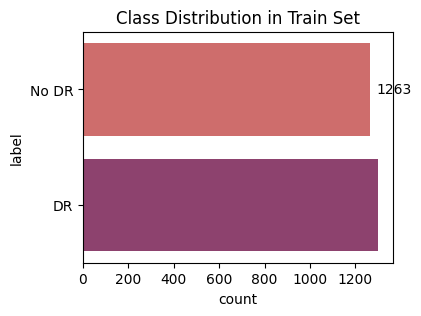

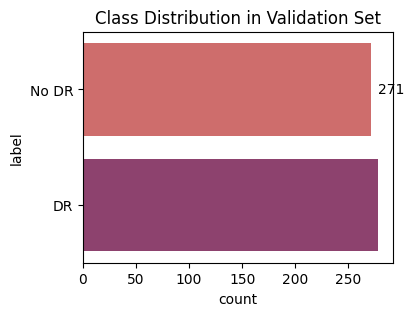

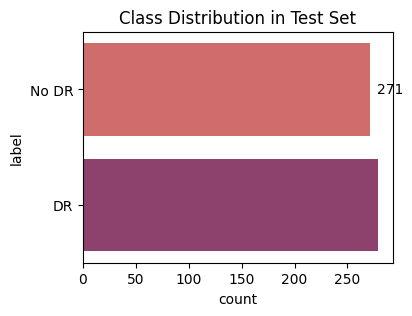

Number of classes: 2


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Base path with binary folders 'DR' and 'No DR'
# Corrected base_path based on the output of cell fsotJ6RtixOS
base_path = "/kaggle/input/aptos-2019-jpg/APTOS 2019 (Original) (Binary)"
# Collect all image paths and their labels
image_paths = []
labels = []

# Iterate through the actual class directories found in the base_path
for class_name in os.listdir(base_path):
    class_dir = os.path.join(base_path, class_name)
    if os.path.isdir(class_dir): # Ensure it's a directory
        # Assuming 'DR' corresponds to label 1 and 'No DR' to label 0
        label = 1 if class_name == 'DR' else 0
        for img_file in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img_file))
            labels.append(label)

# Create DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Split the data - Modified to use single train/validation/test split
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Plot class distribution
datasets = [("Train", train_df), ("Validation", valid_df), ("Test", test_df)]
for name, data in datasets:
    plt.figure(figsize=(4, 3))
    ax = sns.countplot(y=data['label'], palette='flare')
    ax.set_title(f"Class Distribution in {name} Set")
    ax.set_yticklabels(['No DR', 'DR'])
    ax.bar_label(ax.containers[0], fontsize=10, padding=5)
    plt.show()

# Print number of classes
y = df['label'].nunique()
print(f"Number of classes: {y}")

In [ ]:
import os

base_path = "/kaggle/input/aptos-2019-jpg/APTOS 2019 (Original) (Binary)"

print("Contents of base_path:")
print(os.listdir(base_path))

Contents of base_path:
['DR', 'No DR', 'Details.txt']


In [ ]:
def create_model(img_shape, base_model_function, num_classes):
    """
    Create a more complex model with a deep architecture.

    Parameters:
    - img_shape: tuple, shape of the input images (e.g., (224, 224, 3))
    - base_model_function: TensorFlow application model function (e.g., tf.keras.applications.VGG16)
    - num_classes: int, number of output classes

    Returns:
    - Compiled Keras Model
    """
    # Input layer
    inputs = Input(shape=img_shape)

    # Base model (Pre-trained CNN)
    base_model = base_model_function(
        include_top=False,
        weights="imagenet",
        input_shape=img_shape,
        pooling='max'
    )

    # Freeze base model layers
    x = base_model(inputs, training=False)

    # First Dense Block
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Second Dense Block
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Residual Connection
    skip = Dense(256, activation='relu')(x)  # Shortcut Connection
    x = Dense(256, activation='relu')(x)
    x = Add()([x, skip])  # Adding the shortcut connection
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Third Dense Block
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Fourth Dense Block
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Output Layer (Choose activation based on number of classes)
    if num_classes == 1:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    else:
        activation = 'softmax'
        loss = 'categorical_crossentropy'

    outputs = Dense(num_classes, activation=activation)(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=Adamax(learning_rate=0.0005),
        loss=loss,
        metrics=['accuracy', Precision(), Recall()]
    )

    model.summary()
    return model

In [ ]:
def plot_training_metrics(epochs, training_metrics, validation_metrics, title, xlabel, ylabel, best_index, best_value, best_label):
    """
    Plots training and validation metrics over epochs with an emphasis on the best value.
    """
    if len(training_metrics) == 0 or len(validation_metrics) == 0:
        print("Error: Training or validation metrics are empty.")
        return

    # Create the plot
    plt.figure(figsize=(12, 6))  # Larger figure for more space
    plt.plot(epochs, training_metrics, 'r-', label='Training', linewidth=2, markersize=6)
    plt.plot(epochs, validation_metrics, 'g-', label='Validation', linewidth=2, markersize=6)

    # Add a scatter for the best value
    plt.scatter(best_index + 1, best_value, s=200, c='blue', edgecolor='black', label=f'{best_label} ({best_value:.4f})', zorder=5)

    # Annotate the best value point
    plt.text(best_index + 1, best_value + 0.05, f'{best_value:.4f}', color='blue', ha='center', fontsize=12, fontweight='bold')

    # Add horizontal line at best value to emphasize it
    plt.axhline(y=best_value, color='blue', linestyle='--', linewidth=1.5, alpha=0.6)

    # Title and labels
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Enhance legend
    plt.legend(fontsize=12, loc='upper right', title="Metrics", title_fontsize=14)

    # Grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Customize ticks for better clarity
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Tight layout to avoid clipping
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred_classes, test_gen):
    """
    Plots a confusion matrix and displays evaluation metrics.

    Parameters:
        y_true (list or array-like): True labels.
        y_pred_classes (list or array-like): Predicted labels.
        test_gen (object): Test data generator, used to extract class labels.
    """
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Set a larger figure size and create an axis
    fig, ax = plt.subplots(figsize=(12, 10))  # Adjust dimensions as needed

    # Plot the confusion matrix on the specified axis
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices.keys())
    disp.plot(cmap='Blues', ax=ax)  # Assign ax to ensure resizing

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='micro')
    recall = recall_score(y_true, y_pred_classes, average='micro')
    f1 = f1_score(y_true, y_pred_classes, average='micro')

    # Customize plot title and display metrics below the plot
    plt.title("Confusion Matrix", fontsize=16)
    plt.figtext(
        0.5, -0.1,
        f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}",
        ha="center", fontsize=14, color="black"
    )

    # Show the plot with the updated size
    plt.show()

In [ ]:

def confusion(y_true,y_pred_classes):
    cm = confusion_matrix(y_true, y_pred_classes)

    if cm.shape == (2, 2):  # Only compute for binary classification
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall for class 1
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Recall for class 0

        lr_positive = sensitivity / (1 - specificity) if (1 - specificity) > 0 else float('inf')
        lr_negative = (1 - sensitivity) / specificity if specificity > 0 else float('inf')

        print(f"Likelihood Ratio Positive (LR+): {lr_positive:.4f}")
        print(f"Likelihood Ratio Negative (LR-): {lr_negative:.4f}")
    else:
        print("Skipping likelihood ratio computation (not binary classification)")




In [ ]:
# Removed KFold - using single train/validation split
img_size = (256, 256)
img_shape = (256,256,3)
batch_size = 32
loss_threshold=1.5
patience=10
epoch_size = 5

In [ ]:
# Enhanced MetricsCallback to log data to CSV
import csv
import os
from datetime import datetime
import numpy as np # Import numpy here as well
import tensorflow as tf # Import tensorflow here

class CSVMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_generator, model_name, csv_path):
        self.validation_generator = validation_generator
        self.model_name = model_name
        self.csv_path = csv_path
        self.precision = []
        self.recall = []
        self.f1 = []
        self.false_positives = [] # Add list to store False Positives
        self.false_negatives = [] # Add list to store False Negatives

        # Initialize CSV file with headers
        self.init_csv()

    def init_csv(self):
        """Initialize CSV file with headers"""
        headers = [
            'timestamp', 'model_name', 'epoch', 'train_loss', 'train_accuracy',
            'train_precision', 'train_recall', 'val_loss', 'val_accuracy',
            'val_precision', 'val_recall', 'val_f1', 'false_positives', 'false_negatives', 'learning_rate' # Add new headers
        ]

        with open(self.csv_path, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(headers)

    def on_epoch_end(self, epoch, logs=None):
        # Get validation predictions
        val_pred = self.model.predict(self.validation_generator, verbose=0)
        val_pred_classes = np.argmax(val_pred, axis=1)
        val_true = self.validation_generator.classes

        # Calculate validation metrics
        val_precision = precision_score(val_true, val_pred_classes, average='macro', zero_division=0)
        val_recall = recall_score(val_true, val_pred_classes, average='macro', zero_division=0)
        val_f1 = f1_score(val_true, val_pred_classes, average='macro', zero_division=0)

        # Calculate confusion matrix and extract FN and FP for this epoch
        cm = confusion_matrix(val_true, val_pred_classes)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            # Handle non-binary case or set to 0 if not applicable
            fp = 0
            fn = 0
            print(f"Warning: Confusion matrix for epoch {epoch+1} is not 2x2. Cannot calculate FN/FP.")


        # Store metrics
        self.precision.append(val_precision)
        self.recall.append(val_recall)
        self.f1.append(val_f1)
        self.false_positives.append(fp) # Store FP
        self.false_negatives.append(fn) # Store FN


        # Get current learning rate
        current_lr = float(self.model.optimizer.learning_rate)

        # Prepare row data
        row_data = [
            datetime.now().strftime('%Y-%m-%d %H:%M:%S'),  # timestamp
            self.model_name,  # model_name
            epoch + 1,  # epoch (1-indexed)
            logs.get('loss', 0),  # train_loss
            logs.get('accuracy', 0),  # train_accuracy
            logs.get('precision', 0),  # train_precision
            logs.get('recall', 0),  # train_recall
            logs.get('val_loss', 0),  # val_loss
            logs.get('val_accuracy', 0),  # val_accuracy
            val_precision,  # val_precision
            val_recall,  # val_recall
            val_f1,  # val_f1
            fp, # False Positives
            fn, # False Negatives
            current_lr  # learning_rate
        ]

        # Write to CSV
        with open(self.csv_path, 'a', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(row_data)

In [ ]:
def automated_model_training_with_csv_logging(train_df, valid_df, test_df, img_size, batch_size, img_shape, model_list, epoch_size, y, csv_output_path=None):
    """
    Enhanced training function that logs all metrics to CSV files.
    Supports checkpoint resumption, logs training per model, and tracks test metrics.
    """

    import os
    import csv
    import numpy as np
    import re
    from datetime import datetime
    import tensorflow as tf
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

    # Helper: Get latest checkpoint in directory
    def get_latest_checkpoint(checkpoint_dir):
        checkpoint_files = [f for f in os.listdir(checkpoint_dir) if re.match(r'epoch_\d+\.keras', f)]
        if not checkpoint_files:
            return None, 0
        checkpoint_epochs = [int(re.findall(r'\d+', f)[0]) for f in checkpoint_files]
        latest_epoch = max(checkpoint_epochs)
        latest_checkpoint = os.path.join(checkpoint_dir, f"epoch_{latest_epoch:02d}.keras")
        return latest_checkpoint, latest_epoch + 1

    # Output directory for logs
    if csv_output_path is None:
        csv_output_path = '/tmp/training_logs'
    os.makedirs(csv_output_path, exist_ok=True)

    save_path = './saved_models'
    os.makedirs(save_path, exist_ok=True)

    master_csv_path = os.path.join(csv_output_path, 'all_models_training_log.csv')

    # Initialize master CSV file with headers if it doesn't exist
    if not os.path.exists(master_csv_path):
        with open(master_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                'timestamp', 'model_name', 'test_accuracy', 'test_precision',
                'test_recall', 'test_f1', 'false_positives', 'false_negatives'
            ])


    for model_fn in model_list:
        print(f"\nTraining with model: {model_fn.__name__}")

        individual_csv_path = os.path.join(csv_output_path, f'{model_fn.__name__}_training_log.csv')

        # Data generators
        train_df['label'] = train_df['label'].astype(str)
        valid_df['label'] = valid_df['label'].astype(str)
        test_df['label'] = test_df['label'].astype(str)

        train_gen = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2)).flow_from_dataframe(
            train_df, x_col='image_path', y_col='label', batch_size=batch_size, target_size=img_size, class_mode='categorical')

        valid_gen = ImageDataGenerator(rescale=1/255).flow_from_dataframe(
            valid_df, x_col='image_path', y_col='label', batch_size=batch_size, target_size=img_size, class_mode='categorical')

        test_gen = ImageDataGenerator(rescale=1/255).flow_from_dataframe(
            test_df, x_col='image_path', y_col='label', batch_size=16, target_size=img_size, shuffle=False, class_mode='categorical')

        # Model ID & checkpoint setup
        model_id = f"{model_fn.__name__}_single"
        checkpoint_dir = os.path.join(save_path, model_id)
        os.makedirs(checkpoint_dir, exist_ok=True)

        latest_checkpoint, initial_epoch = get_latest_checkpoint(checkpoint_dir)

        # Build model
        model = create_model(img_shape, model_fn, y)

        if latest_checkpoint:
            print(f"Resuming training from: {latest_checkpoint}")
            model.load_weights(latest_checkpoint)
        else:
            print("No checkpoint found. Starting from scratch.")

        # Callbacks
        checkpoint_cb = ModelCheckpoint(
            filepath=os.path.join(checkpoint_dir, "epoch_{epoch:02d}.keras"),
            save_best_only=False,
            save_weights_only=False,
            verbose=1
        )
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
        csv_logger = CSVLogger(os.path.join(checkpoint_dir, "training_log.csv"), append=True)

        # Optional: your custom CSV callback if defined
        callbacks = [checkpoint_cb, csv_logger, early_stopping]
        if 'CSVMetricsCallback' in globals():
            callbacks.append(CSVMetricsCallback(valid_gen, model_fn.__name__, individual_csv_path))


        # Train
        history = model.fit(
            train_gen,
            validation_data=valid_gen,
            epochs=epoch_size,
            shuffle=False,
            initial_epoch=initial_epoch,
            callbacks=callbacks
        )

        # Plotting (functions assumed available)
        epochs = np.arange(1, len(history.history['accuracy']) + 1)
        best_epoch_loss_index = np.argmin(history.history['val_loss'])
        best_epoch_acc_index = np.argmax(history.history['val_accuracy'])

        plot_training_metrics(epochs, history.history['accuracy'], history.history['val_accuracy'],
                              "Training and Validation Accuracy", "Epochs", "Accuracy",
                              best_epoch_acc_index, history.history['val_accuracy'][best_epoch_acc_index],
                              f"Best Epoch = {best_epoch_acc_index + 1}")

        plot_training_metrics(epochs, history.history['loss'], history.history['val_loss'],
                              "Training and Validation Loss", "Epochs", "Loss",
                              best_epoch_loss_index, history.history['val_loss'][best_epoch_loss_index],
                              f"Best Epoch = {best_epoch_loss_index + 1}")

        # Test performance
        y_true = test_gen.classes
        y_pred_classes = np.argmax(model.predict(test_gen), axis=1)

        acc = accuracy_score(y_true, y_pred_classes)
        prec = precision_score(y_true, y_pred_classes, average='macro')
        rec = recall_score(y_true, y_pred_classes, average='macro')
        f1 = f1_score(y_true, y_pred_classes, average='macro')

        # Calculate confusion matrix and extract FN and FP
        cm = confusion_matrix(y_true, y_pred_classes)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            # Handle non-binary case if needed, or set FN/FP to 0
            fp = 0
            fn = 0
            print("Warning: Confusion matrix is not 2x2. Cannot calculate FN/FP.")


        # Save test results to master CSV
        test_results_csv = os.path.join(csv_output_path, 'final_test_results.csv')
        file_exists = os.path.exists(test_results_csv)
        with open(test_results_csv, 'a', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            if not file_exists:
                writer.writerow(['timestamp', 'model_name', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'false_positives', 'false_negatives'])
            writer.writerow([
                datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                model_fn.__name__,
                acc, prec, rec, f1, fp, fn
            ])

        # Visualize and print
        print(f"\nResults for model: {model_fn.__name__}")
        print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
        print(f"False Positives: {fp} | False Negatives: {fn}")

        plot_confusion_matrix(y_true, y_pred_classes, test_gen)
        confusion(y_true, y_pred_classes)

        # Save model if it did well
        if acc > 0.90:
            model_save_path = os.path.join(save_path, f"{model_fn.__name__}_single_split.keras")
            model.save(model_save_path)
            print(f"✅ Model saved to {model_save_path} (Accuracy: {acc:.4f})")

        print(f"Training log saved to: {individual_csv_path}")
        print("-" * 50)

    print(f"\nAll CSV files saved to: {csv_output_path}")
    print(f"Master training log: {master_csv_path}")
    print(f"Final test results: {test_results_csv}")


Training with model: EfficientNetV2B0
Found 2563 validated image filenames belonging to 2 classes.
Found 549 validated image filenames belonging to 2 classes.
Found 550 validated image filenames belonging to 2 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 1280)      │  5,919,312 │ input_layer_2[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │    655,872 │ efficientnetv2-b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    131,328 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │     65,792 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │     65,792 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_10[0][0],   │
│                     │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ add_1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     32,896 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_11[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      8,256 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 2)         │        130 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,884,242 (26.26 MB)

 Trainable params: 6,821,202 (26.02 MB)

 Non-trainable params: 63,040 (246.25 KB)

No checkpoint found. Starting from scratch.
Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5989 - loss: 0.8989 - precision_1: 0.5989 - recall_1: 0.5989
Epoch 1: saving model to ./saved_models/EfficientNetV2B0_single/epoch_01.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.5997 - loss: 0.8971 - precision_1: 0.5997 - recall_1: 0.5997 - val_accuracy: 0.7432 - val_loss: 0.5317 - val_precision_1: 0.7432 - val_recall_1: 0.7432
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7821 - loss: 0.5091 - precision_1: 0.7821 - recall_1: 0.7821
Epoch 2: saving model to ./saved_models/EfficientNetV2B0_single/epoch_02.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.7823 - loss: 0.5088 - precision_1: 0.7823 - recall_1: 0.7823 - val_accuracy: 0.6648 - val_loss: 0.5605 - val_precision_1: 0.6648 - val_recall_1: 0.6648
Epoch 3/5
80/81 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8444 - loss: 0.3991 - precision_1: 0.8444 - recall_1: 0.8444
Epoch 3: saving m

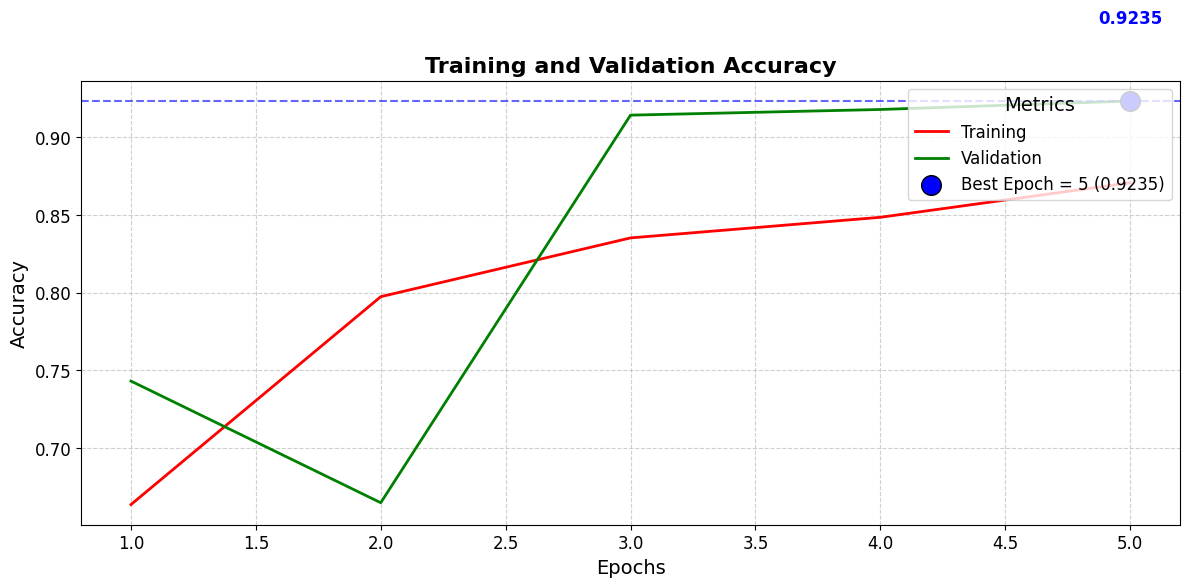

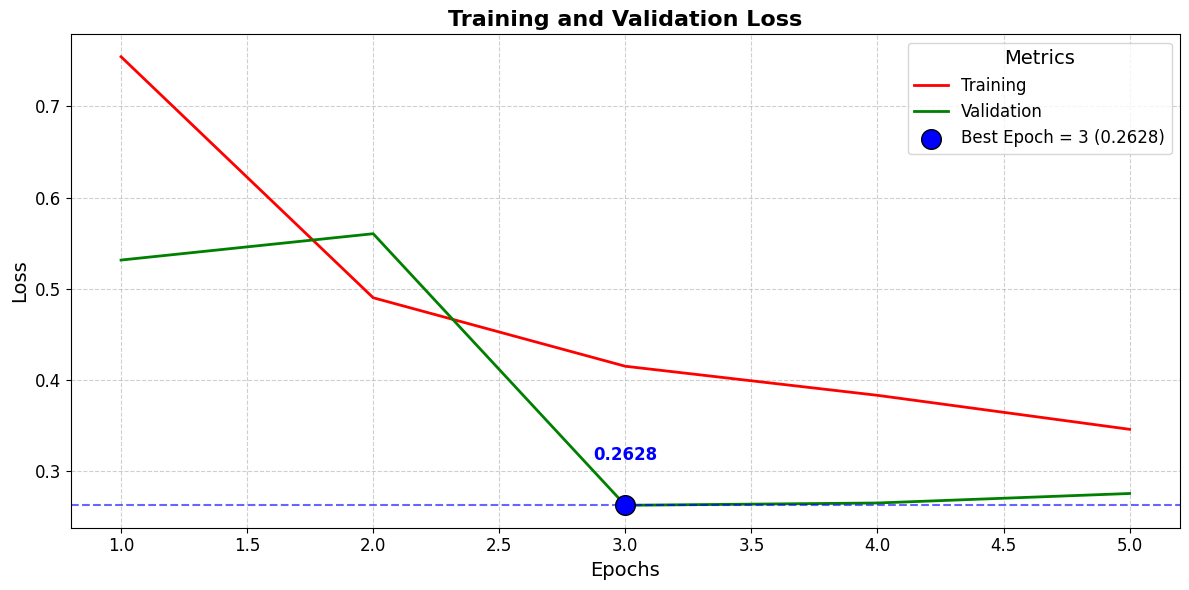

35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 915ms/step

Results for model: EfficientNetV2B0
Accuracy: 0.9200 | Precision: 0.9205 | Recall: 0.9198 | F1: 0.9199
False Positives: 26 | False Negatives: 18


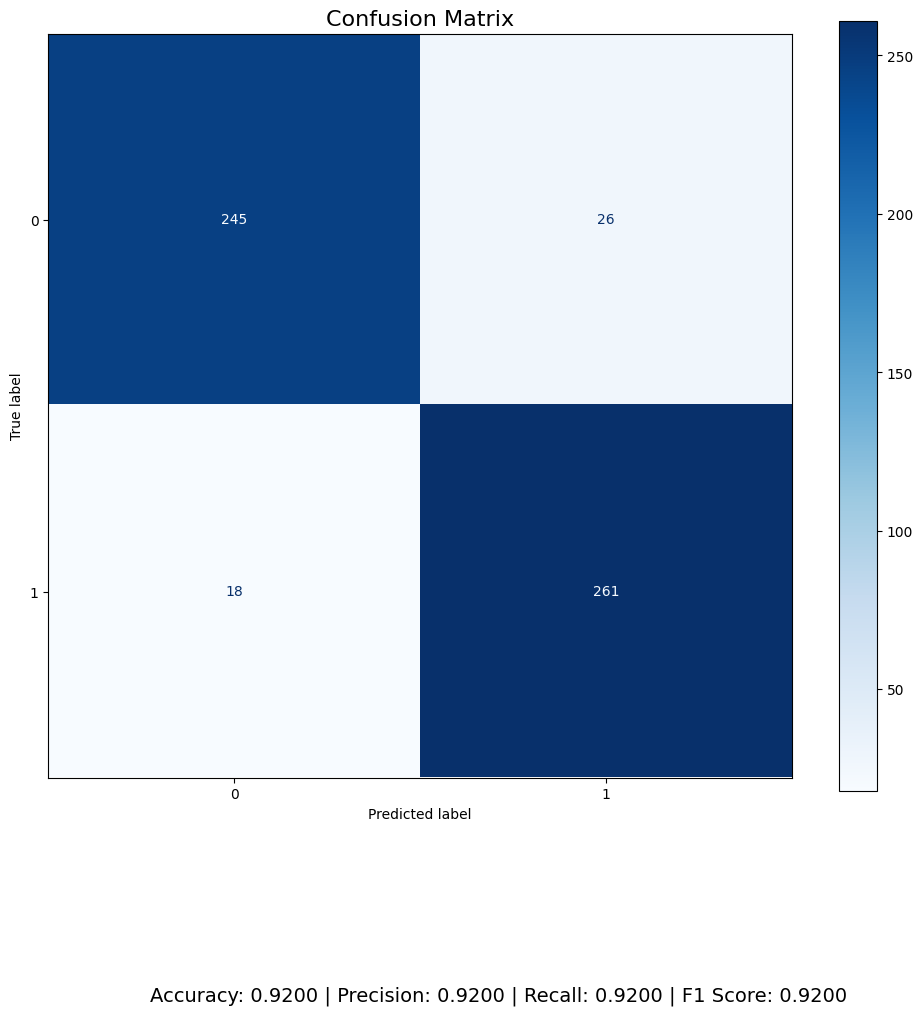

Likelihood Ratio Positive (LR+): 9.7506
Likelihood Ratio Negative (LR-): 0.0714
✅ Model saved to ./saved_models/EfficientNetV2B0_single_split.keras (Accuracy: 0.9200)
Training log saved to: /tmp/training_logs/EfficientNetV2B0_training_log.csv
--------------------------------------------------

All CSV files saved to: /tmp/training_logs
Master training log: /tmp/training_logs/all_models_training_log.csv
Final test results: /tmp/training_logs/final_test_results.csv


In [ ]:
models_to_evaluate = [
    #tf.keras.applications.MobileNetV2,  # Best for mobile/edge (lightweight, strong performance)
    #tf.keras.applications.EfficientNetB0,  # State-of-the-art accuracy-to-size ratio
    #tf.keras.applications.Xception,  # High accuracy with depthwise separable convolutions
    #tf.keras.applications.MobileNetV3Small,  # Improved over V2 with NAS optimization
    tf.keras.applications.EfficientNetV2B0,  # Faster training + better efficiency than B0
    #tf.keras.applications.VGG16, # A widely used standard CNN architecture
    #tf.keras.applications.ResNet50, # Popular for its residual connections
   # tf.keras.applications.DenseNet121 # Known for its dense connections
]

# Run training with single split (no K-fold)
automated_model_training_with_csv_logging(train_df, valid_df, test_df, img_size, batch_size, img_shape, models_to_evaluate, epoch_size, y)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
from PIL import Image
import os

# Method 1: Check if model file exists and get correct path
def find_model_file():
    """Find the model file in common locations"""
    # UPDATED: Based on your fixed training script, models are saved in ./saved_models/
    save_directories = [
        './saved_models',           # Current working directory (from fixed training script)
        '/tmp/saved_models',        # Previous location
        '/content/saved_models',    # Alternative location
        '/content',                 # Colab default
        '.'                        # Current directory
    ]

    # Check all possible model files (both .keras and .h5)
    model_patterns = [
        'EfficientNetV2B0_single_split.keras',
        'EfficientNetV2B0_single_split.h5',
        'MobileNetV2_single_split.keras',
        'MobileNetV2_single_split.h5',
        'EfficientNetB0_single_split.keras',
        'EfficientNetB0_single_split.h5',
        'Xception_single_split.keras',
        'Xception_single_split.h5',
        'VGG16_single_split.keras',
        'VGG16_single_split.h5',
        'ResNet50_single_split.keras',
        'ResNet50_single_split.h5',
        'DenseNet121_single_split.keras',
        'DenseNet121_single_split.h5'
    ]

    # Search in all directories
    for directory in save_directories:
        if os.path.exists(directory):
            print(f"Checking directory: {directory}")

            # Look for specific model patterns first
            for pattern in model_patterns:
                full_path = os.path.join(directory, pattern)
                if os.path.exists(full_path):
                    print(f"✅ Found model: {full_path}")
                    return full_path

            # Look for any .keras or .h5 files
            model_files = [f for f in os.listdir(directory)
                          if f.endswith(('.keras', '.h5'))]
            if model_files:
                print(f"Found model files in {directory}: {model_files}")
                # Prefer .keras files over .h5
                keras_files = [f for f in model_files if f.endswith('.keras')]
                if keras_files:
                    selected_file = os.path.join(directory, keras_files[0])
                else:
                    selected_file = os.path.join(directory, model_files[0])
                print(f"✅ Selected: {selected_file}")
                return selected_file

    print("❌ No model files found in any location")
    return None

# Method 2: Upload model file if not found
def upload_model():
    """Upload model file from local machine"""
    print("Please upload your trained model file (.h5):")
    uploaded = files.upload()
    if uploaded:
        model_filename = list(uploaded.keys())[0]
        return f'/content/{model_filename}'
    return None

# Try to find existing model or upload one
model_path = find_model_file()

if model_path is None:
    print("Model file not found. Please upload your model:")
    model_path = upload_model()

if model_path is None:
    print("No model file provided. Please upload a trained model file.")
    exit()

try:
    # Load the trained model
    print(f"Loading model from: {model_path}")
    loaded_model = load_model(model_path)
    print("Model loaded successfully!")

    # Print model summary
    print("\nModel Summary:")
    loaded_model.summary()

except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Define image size (adjust based on your model's input size)
# Based on your training script, you used (256, 256)
img_size = (256, 256)  # This matches your training data size

# Upload and preprocess the image
print("\nPlease upload an image for prediction:")
uploaded = files.upload()

for fn in uploaded.keys():
    try:
        print(f"\nProcessing image: {fn}")

        # Load and preprocess image
        img_bytes = uploaded[fn]
        img = Image.open(io.BytesIO(img_bytes))

        # Convert to RGB if needed (in case of grayscale or RGBA)
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Resize image
        img = img.resize(img_size)

        # Convert to array and preprocess
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Rescale the image

        print(f"Image shape after preprocessing: {img_array.shape}")

        # Make prediction
        predictions = loaded_model.predict(img_array)
        print(f"Raw predictions: {predictions}")

        # Interpret the prediction
        # Based on your training script using categorical crossentropy with 2 classes
        if len(predictions[0]) == 2:
            # Your model outputs [No DR probability, DR probability]
            predicted_class = np.argmax(predictions[0])
            confidence = np.max(predictions[0])

            if predicted_class == 0:
                prediction_label = 'No DR'
            else:
                prediction_label = 'DR'

        elif len(predictions[0]) == 1:
            # Single output (sigmoid) - less likely based on your code
            confidence = predictions[0][0]
            prediction_label = 'DR' if confidence > 0.5 else 'No DR'
        else:
            # Multi-class classification
            predicted_class = np.argmax(predictions[0])
            confidence = predictions[0][predicted_class]
            # Define your class labels here based on original APTOS dataset
            class_labels = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
            if predicted_class < len(class_labels):
                prediction_label = class_labels[predicted_class]
            else:
                prediction_label = f'Class {predicted_class}'

        print(f"The image '{fn}' is classified as: {prediction_label}")
        print(f"Confidence: {confidence:.4f}")

        # Display the image
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"Prediction: {prediction_label} (Confidence: {confidence:.2f})")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error processing image {fn}: {e}")
        continue

print("\nPrediction complete!")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')